# ML Enablement Workshop: サービスの解約率改善シナリオ

サービスの解約率改善をテーマに、MLOpsのプロセスのビジネス理解から評価までを体験できるシナリオです。

## コンテンツ

事前準備

* 環境構築

シナリオ

1. ビジネス理解: Business Understanding
2. データ分析: Analyze
3. データ充足: Prepare
4. 前処理: Preprocess
5. 学習: Train
6. 評価: Test
   1. 性能評価
   1. コスト分析
   1. 最適な閾値を探す

---
## 環境構築

プロジェクトを進めるために、機械学習モデルの開発環境を構築します。

今回は Amazon SageMaker Studio Lab を使用し、 Conda による環境構築を行います。 `scenario_churn` フォルダにある `environment.yml` を右クリックして `Build Conda Environment` をクリックすると環境が構築できます。

![environment_setup_001.png](./images/001.png)

完了したら、Jupyter Notebookの右上にある虫の隣のボタンをクリックしカーネルを切り替えます(作成した仮想環境が反映されるまでに少し時間がかかります)。

![environment_setup_002.png](./images/002.png)

ターミナルから環境を構築する場合は、[こちら](https://github.com/aws-samples/aws-ml-enablement-workshop/blob/main/notebooks/00_environment_setup.ipynb)をご確認ください。

環境構築の詳細を知りたい方は、 [機械学習モデルの開発環境を構築する](https://youtu.be/C8VYnJ-DF3I) をご参照ください。

---

## 1.ビジネス理解: Business Understanding

どのようなビジネスであっても、顧客を失うことは大きな損害です。このシナリオでは、サービスに満足していない顧客を機械学習 (Machine Learning, ML) で自動で認識してアクションをとれるようにする方法を説明します。このような顧客離れの分析は Customer Churn Prediction と呼ばれています。

今回は携帯電話会社での顧客離れ防止を取り上げます。携帯電話会社が、ある顧客が解約しそうと察知したら、その顧客にタイムリーにインセンティブを与えます。インセンティブとは、電話のアップグレードやクーポン(※)、新機能の紹介などです。インセンティブにより引き続き携帯電話会社を使おうと思うかもしれません。インセンティブは、顧客が解約して再度獲得するまでにかかるコストよりもずっと小さいことが多いです。

※解約するふりをするとクーポンがもらえるという仕組みはユーザーの質を下げるため、顧客離反防止のためにクーポンを発行するケースは少ないと思います。

素朴なビジネス上の欲求として、最小のコストで解約を防ぎたいものです。今回はビジネス KPI を軸に機械学習で解く課題の設定をします。

1. ビジネス課題を定義する
2. 課題解決のシナリオを描く
3. MLのプロセスを特定する

### 1.1 ビジネス課題を定義する

課題とは、現状 (As-is) と 理想状態 (To-be) のギャップです。今回は、携帯電話会社で顧客獲得競争のため CAC が LTV の 1 / 2 と割高になっているのが現状で、理想状態として CAC が LTV の 1 / 3 以下に抑えられていることとします。

聞きなじみがない単語がばらばらと出てきてうんざりしたかもしれません。ディープラーニングの実装にすぐ取り掛かりたいかもしれませんが、機械学習の活用プロジェクトが失敗するのはビジネス理解のフェーズをきちんと行わなかったことが理由であることがほとんどです(詳細が気になる方は[機械学習の価値を計算する](https://youtu.be/csiMBxUkAEc)をぜひご視聴ください)。プロジェクトを成功させるために、ビジネスの課題がどういうものなのか明らかにしましょう。

機械学習活用プロジェクトが失敗する理由のTop5:

1. **ビジネスの目標がはっきりしていない**
2. データの品質が不十分
3. プロジェクトのスポンサーが不在
4. **チーム間の連携が不十分**
5. データサイエンティストなどの専門職の不在

LTV (Life Time Value) は顧客一人当たりの価値を表す値で、利益ベースの場合次の式で計算できます。

* LTV = 顧客一人当たりの月次利益 x 平均利用月数
  * = **顧客一人当たりの月次利益 / 月の解約率**

平均利用月数と 1 / 月の解約率が等価になります。継続するということは解約しないということなので、利用月数の期待値は、初月は 1 - 解約率 、次月は ( 1 - 解約率 )^2 ・・・と継続月数分だけ続け、和を取ることになります。数学 B の等比数列の公式を使うとこの式を導けます。

![LTVの説明](images/005.png)

CAC (Customer Acquisition Cost) は顧客一人当たりの獲得コストです。LTV が CAC を上回っていないと、いわば原価割れしている状態になります。一般的には、 CAC を LTV の 1 / 3 に抑えることが重要といわれています。

現状の LTV は 450,000 (※)、 CAC は　200,000 と仮定します。 CAC が LTV の 2.25 なので、理想状態と乖離があります。これが「ビジネス課題」です。

※ LTV の計算について、顧客一人当たりの月次売上を 5,000 円、顧客の解約防止にかけるコストを 10% の 500 円とし、差し引き 4,500 円を顧客一人当たりの月次利益としました。解約率を 1% とし、 4,500 / 0.01 で 450,000 となります。LTV から逆算すると約 100 カ月、8 年使う計算ですが 5 年以上使う方が半数以上との調査があるので、おおむね的を得ている計算結果と思います。

### 1.2 課題解決のシナリオを描く

理想状態に至るための打ち手は、次のように整理できます。

* LTV の向上
   * 顧客一人当たりの月次利益を向上する
   * 解約率を下げる
* CAC の削減

携帯電話各社の競争は厳しく、 CAC は下げられない、 LTV (≒利用料金) も上げられない。解約率は現状 1% ですが業界トップの D 社は 0.6% と開きがあり、ここに伸びしろがあると結論付けられたとします。そこで、課題解決のシナリオとして、解約率を 0.6% と業界最低水準にし、LTV を 4,500 / 0.006 = 750,000 と、 CAC の 3.75 倍を目指すというシナリオを描きます。

### 1.3 MLのプロセスを特定する

課題解決のシナリオにおいて機械学習の出番はあるか特定します。シナリオの重要な点は、解約率を下げつつも LTV 構成要素である利益は維持しなければならない、つまりコストは現状の売上の 10% ( 500 円 ) を超過できないことです。効率的に解約率を下げる必要があり、解約防止のためのインセンティブを最適化するのに機械学習が役立ちそうです。

プロダクトマネージャーなどビジネスを検討する人とコミュニケーションを取り、課題解決のシナリオ、そこでの機械学習の役割を確認する必要があります。今回は、次のプロジェクト目標が設定され予算が承認されたとします。

**解約率を0.6%にしつつ、顧客一人当たりの解約防止コストを500円(売上の10%)に維持することが可能か否かを、3カ月(1Q)で確認する。**

この目標の達成は機械学習モデルの精度だけでなくマーケティング部門のオペレーションにも大きく左右されます。なぜなら、解約防止のインセンティブを検討・送付するのはマーケティング部門などになるからです (少なくとも機械学習モデルの開発チームではないでしょう) 。そのため、プロジェクト開始前に課題解決のシナリオに関わるステークホルダーを明らかにし、協力を仰ぐことが成功に不可欠です。機械学習活用プロジェクトが失敗する理由の多くはビジネス理解のプロセスで防ぐことができます。

### 参考文献

* [ゴリゴリの実務者が書いた、LTVを正しく理解・計算する3つのステップ](https://note.biz.moneyforward.com/n/n58355972b335)
* [スマートフォン利用者の月額利用料金は4,617円](https://www.m2ri.jp/release/detail.html?id=525)
* [キャンペーンや新料金プランで市場が流動化し、解約率は3社揃って上昇](https://k-tai.watch.impress.co.jp/docs/column/mca/1345010.html#:~:text=%E5%90%84%E7%A4%BE%E5%85%AC%E8%A1%A8%E6%95%B0%E5%80%A4%E3%81%8B%E3%82%89%E3%80%81%E3%82%B9%E3%83%9E%E3%83%BC%E3%83%88%E3%83%95%E3%82%A9%E3%83%B3,%E3%81%A6%E4%B8%8A%E6%98%87%E3%81%97%E3%81%A6%E3%81%84%E3%82%8B%E3%80%82)
* [「携帯電話の違約金1,000円」の認知度は75.4％](https://mmdlabo.jp/investigation/detail_1806.html)
* [カスタマーサクセスの費用事情：世界のSaaS企業はお金をどう使っているの？](https://success-lab.jp/20171014-2/)

---

## 2.データ分析 : Analyze

モデルを構築する前に、データ分析を行います。ビジネス理解で設定した目標を達成するのに今あるデータの質・量が十分か確認するためです。

携帯電話会社は、どの顧客が最終的に解約したか、または、サービスを使い続けたかの履歴データをもっています。顧客の履歴データの格納先は企業によって様々です。開発チームではなくマーケティングチームが利用しているサービスに格納されていることもあるでしょう。サービスによっては、最新データしか保持しないためETLツールを使って定期的にデータウェアハウスへロードして履歴データを作る必要があるかもしれません。

* Salesforce
* HubSpot
* Relational Database (MySQLやPostgreSQLなど)
* Firestore
* Google SpreadSheet / Notion
* Google Analytics (BigQuery)

今回は、素晴らしいことにデータがすでに手に入っていることとします。ここで利用するデータセットは書籍 [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) で Daniel T. Larose が言及しているもので、一般に利用可能です。データセットは、著者によって University of California Irvine Repository of Machine Learning Datasets へ提供されています。

データを集める必要がある場合、関係部門へ依頼する必要があります。この時、ビジネス理解のフェーズでビジネス目標を明確にし、共有しておくと協力が得やすくなります。単にデータ分析で何かやってみたいからデータをくださいと依頼するのと、「業界トップの解約率0.5%を達成し LTV を最大化するために・・・」という目標の元協力を仰ぐのとでは、結果が大きく異なるでしょう。

では、データ分析を始めましょう。はじめに、使用するライブラリを読み込みます。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import xgboost

`data/raw`フォルダにある`churn.txt` を `pandas` を利用して読み込みます。 `pandas` は、表形式のデータを読み込んで、様々な加工ができるライブラリです。

In [2]:
data_root = Path("../../data/")
churn = pd.read_csv(data_root.joinpath("raw/churn.txt"))
pd.set_option("display.max_columns", len(churn.columns))
churn

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0       PA             163        806  403-2562         no        yes   
1       SC              15        836  158-8416        yes         no   
2       MO             131        777  896-6253         no        yes   
3       WY              75        878  817-5729        yes        yes   
4       WY             146        878  450-4942        yes         no   
...    ...             ...        ...       ...        ...        ...   
4995    NH               4        787  151-3162        yes        yes   
4996    SD             140        836  351-5993         no         no   
4997    SC              32        836  370-3127         no        yes   
4998    MA             142        776  604-2108        yes        yes   
4999    AL             141        657  294-2849        yes        yes   

      VMail Message   Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  \
0               300   8.162204          3    7.579174  3.933035          4   
1                 0  10.018993          4    4.226289  2.325005          0   
2               300   4.708490          3    4.768160  4.537466          3   
3               700   1.268734          3    2.567642  2.528748          5   
4                 0   2.696177          3    5.908916  6.015337          3   
...             ...        ...        ...         ...       ...        ...   
4995            800  10.862632          5    7.250969  6.936164          1   
4996              0   1.581127          8    3.758307  7.377591          7   
4997            700   0.163836          5    4.243980  5.841852          3   
4998            600   2.034454          5    3.014859  4.140554          3   
4999            500   1.803907          0    5.125716  8.357508          0   

      Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  \
0       6.508639    4.065759          100      5.111624   4.928160   
1       9.972592    7.141040          200      6.436188   3.221748   
2       4.566715    5.363235          100      5.142451   7.139023   
3       2.333624    3.773586          450      3.814413   2.245779   
4       3.670408    3.751673          250      2.796812   6.905545   
...          ...         ...          ...           ...        ...   
4995    8.026482    4.921314          350      6.748489   4.872570   
4996    1.328827    0.939932          300      4.522661   6.938571   
4997    2.340554    0.939469          450      5.157898   4.388328   
4998    3.470372    6.076043          150      4.362780   7.173376   
4999    2.109823    2.624299          400      3.713631   5.798783   

      Intl Calls  Intl Charge  CustServ Calls  Churn?  
0              6     5.673203               3   True.  
1              6     2.559749               8  False.  
2              2     6.254157               4  False.  
3              6     1.080692               6  False.  
4              4     7.134343               6   True.  
...          ...          ...             ...     ...  
4995           8     2.122530               9  False.  
4996           2     4.600473               4  False.  
4997           7     1.060340               6  False.  
4998           3     4.871900               7   True.  
4999           6     5.485345               7  False.  

[5000 rows x 21 columns]

データは 5,000 行で、現在の機械学習としてはやや小さいデータセットです。各データのレコードは、ある米国の携帯電話会社の顧客プロフィールに関する 21 の属性からなります。

- `State` : 顧客が居住している米国州で、2文字の省略形で記載されます (OHとかNJのように)
- `Account Length` : アカウントが利用可能になってからの経過日数
- `Area Code` : 顧客の電話番号に対応する3桁のエリアコード
- `Phone` : 残りの7桁の電話番号
- `Int’l Plan` : 国際電話のプランに加入しているかどうか (yes/no)
- `VMail Plan` : Voice mail の機能を利用しているかどうか (yes/no)
- `VMail Message` : 1ヶ月の Voice mail のメッセージの平均長
- `Day Mins` : 1日に通話した時間(分)の総和
- `Day Calls` : 1日に通話した回数の総和
- `Day Charge` : 日中の通話にかかった料金
- `Eve Mins, Eve Calls, Eve Charge` : 夜間通話にかかった料金
- `Night Mins`, `Night Calls`, `Night Charge` : 深夜通話にかかった料金
- `Intl Mins`, `Intl Calls`, `Intl Charge` : 国際通話にかかった料金
- `CustServ Calls` : カスタマーサービスに電話をかけた回数
- `Churn?` : そのサービスから解約したかどうか (true/false)

**Discussion**

*皆さんのサービスで似たような項目はあるでしょうか? `Int’l Plan` や `VMail Plan` は有償プランや特定機能の利用有無、 `Day Mins` や `Day Calls` は 1 日の利用時間、 1 日のログイン回数などに置き換えて考えられるかもしれません。*

最後の属性 `Churn?` が機械学習モデルで予測する対象になります。予測の対象は**目的変数**と呼ばれます。今回の目的変数は 2 値 (binary) なので、今回作成するモデルは 2 値の予測を行います。これは 2 値分類といわれます。

それではデータを詳しく見てみます。まずは各列のデータ型を確認します。

In [3]:
churn.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

`object` 形式のデータは、選択式項目や文字列のデータです。こうした変数を **カテゴリ変数** と呼びます。たとえば、ユーザーの所在地 ( 千葉県や東京都 ) サービス利用有無です。

カテゴリ変数から分析していきましょう。`describe()` を利用すると各属性の統計量を一度に見ることができます。

In [4]:
churn.select_dtypes(include=['object']).describe()

State     Phone Int'l Plan VMail Plan  Churn?
count   5000      5000       5000       5000    5000
unique    51      4999          2          2       2
top       RI  614-5668         no        yes  False.
freq     120         2       2507       2512    2502

`count` は件数、 `unique` は項目数です。 `yes` / `no` の 2 値である `Int'l Plan` は 2 になっています。当然ですが電話番号である `Phone` は件数と項目数が一致するはずです ( 1 件ずれているのは、本当なら確認が必要かもしれません ) 。

データ型、カテゴリ変数の統計量から次の洞察が得られます。

* `Area code` は本来 `object` として扱うべきですが数値データとみなされているようなので、非数値に変換しましょう。
* `Phone` については、ユーザーに対しほぼ一意のIDとなっています。 Idから解約するか予測できるわけではないので、使うのは止めるべきでしょう(ただ、最初の3桁はなにか意味がありそうなので、意味があるとわかれば分析する価値はあるかもしれません)。

`Area code` の変換と、 `Phone` の削除を行います。

In [5]:
churn['Area Code'] = churn['Area Code'].astype(object)
churn = churn.drop('Phone', axis=1)

カテゴリ変数について、値の出現頻度に偏りがあるか確認します。例えば一部の地区のデータしかなかったら、他の地区のデータを拡充したほうがよいでしょう。

`pandas` では `value_counts` を使い値の出現数を数えられます。 `normalize=True` を指定すると出現数から割合を計算できます。

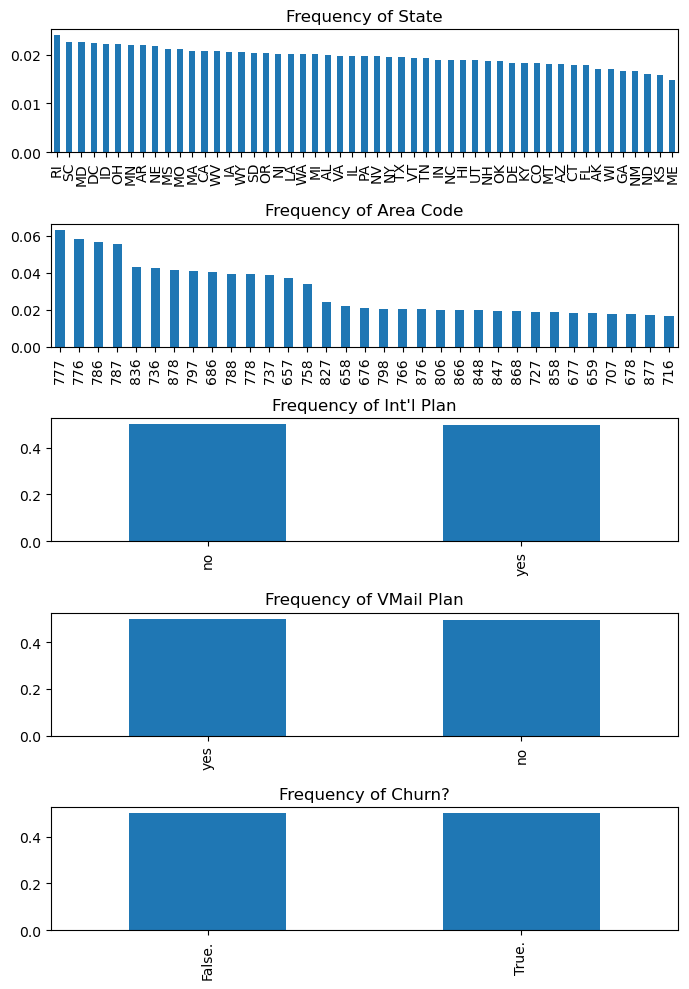

In [6]:
categorical_columns = churn.select_dtypes(include=['object']).columns
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(7, 10))
for i, column in enumerate([c for c in churn.select_dtypes(include=["object"]).columns]):
        title = f"Frequency of {column}"
        churn[column].value_counts(normalize=True).sort_values(ascending=False).plot.bar(title=title, ax=axes[i])
plt.tight_layout()

データセット中に偏りがあまりないことがわかります。

次に、目的変数 `Churn?` が True か False かで、出現頻度に差があるか見てみます。

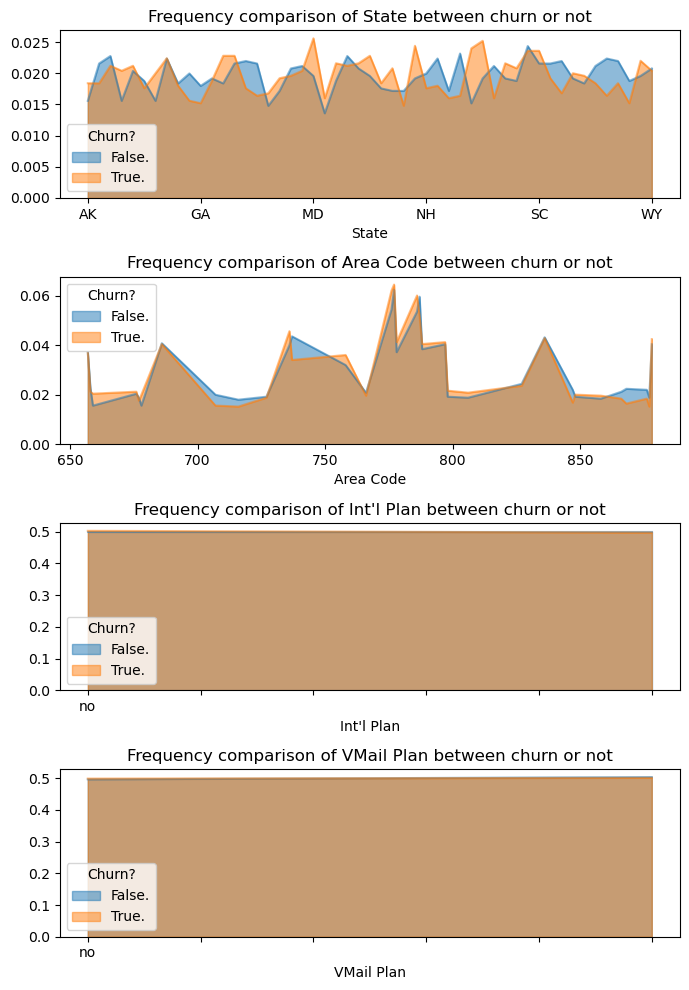

In [7]:
fig, axes = plt.subplots(nrows=len(categorical_columns) - 1, ncols=1, figsize=(7, 10))
for i, column in enumerate([c for c in categorical_columns if c != "Churn?"]):
        title = f"Frequency comparison of {column} between churn or not"
        pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize='columns').plot.area(title=title, ax=axes[i], stacked=False)
plt.tight_layout()

カテゴリ変数のデータ分析から次のことが読み取れます。

- 各項目の頻度はだいたい一様に分布しています。解約したか否かでも分布は変わりません。

続いて、数値である **量的変数** のデータに関して統計量とデータの分布を確認します。

In [8]:
churn.select_dtypes(exclude=['object']).describe()

Account Length  VMail Message     Day Mins   Day Calls   Day Charge  \
count     5000.000000    5000.000000  5000.000000  5000.00000  5000.000000   
mean       101.675800     226.680000     5.518757     3.50460     5.018902   
std         57.596762     273.998527     3.433485     1.68812     2.195759   
min          1.000000       0.000000     0.000215     0.00000     0.004777   
25%         52.000000       0.000000     2.682384     2.00000     3.470151   
50%        102.000000       0.000000     5.336245     3.00000     4.988291   
75%        151.000000     400.000000     7.936151     5.00000     6.559750   
max        200.000000    1300.000000    16.897529    10.00000    12.731936   

          Eve Mins    Eve Calls   Eve Charge   Night Mins  Night Calls  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      5.026199     3.140400     5.017557     4.000917   224.790000   
std       2.135487     2.525621     2.127857     1.631001    97.302875   
min       0.004659     0.000000     0.013573     0.008468     0.000000   
25%       3.588466     1.000000     3.529613     2.921998   150.000000   
50%       5.145656     3.000000     5.006860     3.962089   200.000000   
75%       6.552962     5.000000     6.491725     5.100128   300.000000   
max      13.622097    14.000000    12.352871    10.183378   550.000000   

       Night Charge    Intl Mins   Intl Calls  Intl Charge  CustServ Calls  
count   5000.000000  5000.000000  5000.000000  5000.000000     5000.000000  
mean       5.023490     5.025876     5.475400     4.328242        5.525800  
std        1.748900     1.019302     1.877045     2.440311        2.041217  
min        0.054863     1.648514     0.000000     0.000769        0.000000  
25%        3.873157     4.349726     4.000000     2.468225        4.000000  
50%        5.169154     5.034905     5.000000     4.214058        6.000000  
75%        6.272015     5.716386     7.000000     5.960654        7.000000  
max       10.407778     8.405644    12.000000    14.212261       13.000000

array([[<AxesSubplot:title={'center':'Account Length'}>,
        <AxesSubplot:title={'center':'VMail Message'}>,
        <AxesSubplot:title={'center':'Day Mins'}>,
        <AxesSubplot:title={'center':'Day Calls'}>],
       [<AxesSubplot:title={'center':'Day Charge'}>,
        <AxesSubplot:title={'center':'Eve Mins'}>,
        <AxesSubplot:title={'center':'Eve Calls'}>,
        <AxesSubplot:title={'center':'Eve Charge'}>],
       [<AxesSubplot:title={'center':'Night Mins'}>,
        <AxesSubplot:title={'center':'Night Calls'}>,
        <AxesSubplot:title={'center':'Night Charge'}>,
        <AxesSubplot:title={'center':'Intl Mins'}>],
       [<AxesSubplot:title={'center':'Intl Calls'}>,
        <AxesSubplot:title={'center':'Intl Charge'}>,
        <AxesSubplot:title={'center':'CustServ Calls'}>, <AxesSubplot:>]],
      dtype=object)

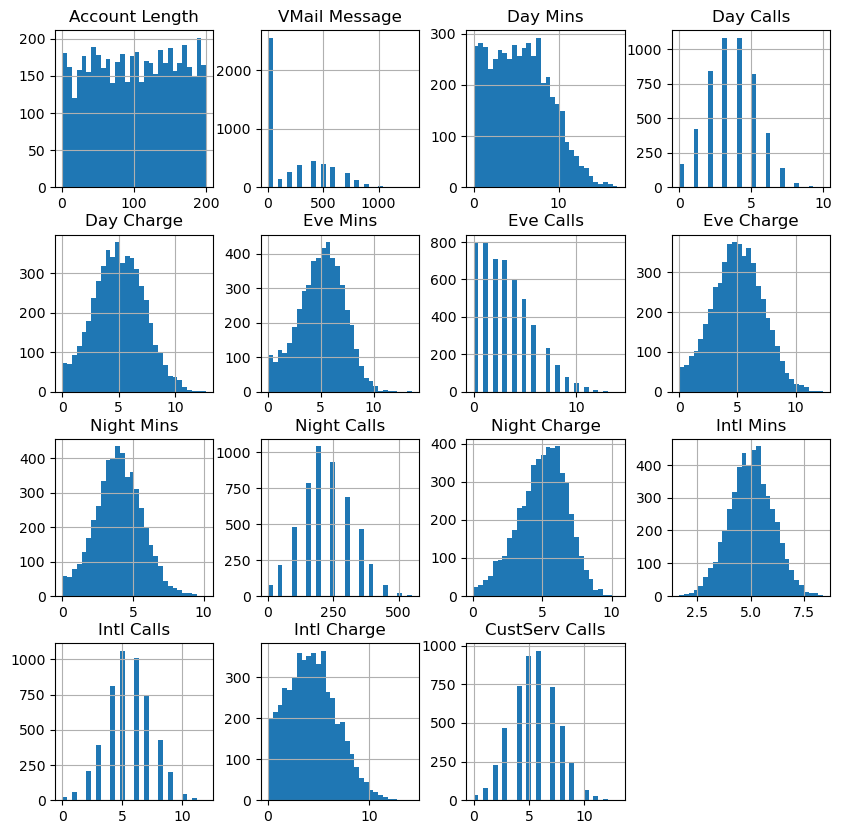

In [9]:
churn.select_dtypes(exclude=['object']).hist(bins=30, figsize=(10, 10))

数値項目の多くは正規分布のような釣り鐘の分布になっています。ただ、`VMail Message` は例外です。  
数値項目も、目的変数 `Churn?` が True か False かで分布が変わるか見てみます。オレンジが解約、青が解約しないユーザーです。

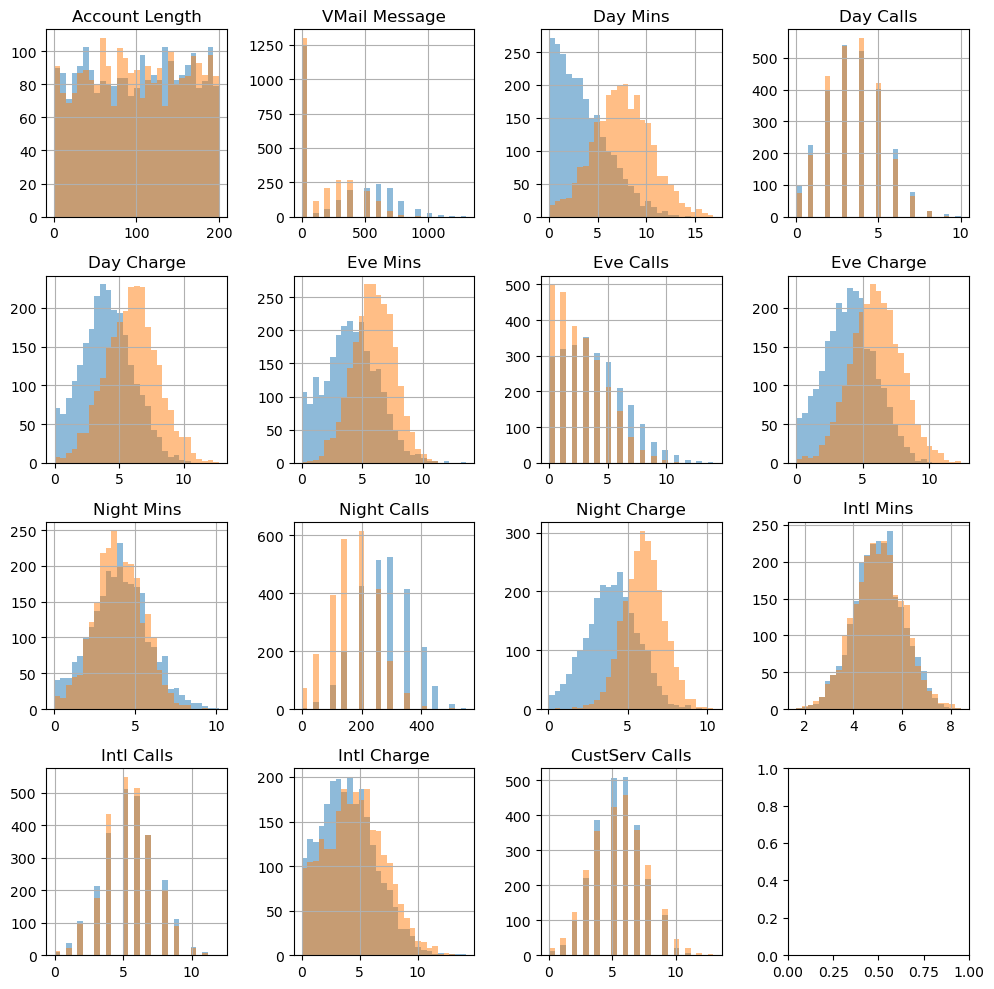

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, column in enumerate(churn.select_dtypes(exclude=['object']).columns):
    row = i // 4
    col = i % 4
    hist = churn[[column, "Churn?"]].groupby("Churn?").hist(
            bins=np.linspace(churn[column].min(),
            churn[column].max(), 30), ax=axes[row, col], alpha=0.5)

plt.tight_layout()

カテゴリ変数、量的変数のデータ分析の結果から、解約する顧客について、以下のような傾向が見られます。

- 地理的にほぼ一様に分散している
- VoiceMailをあまり利用していない
- 通話時間で見ると長い通話時間と短い通話時間の人に分かれる( `Day Mins` ,  `Day Charge` など)
- カスタマーサービスへの通話が若干多い (多くの問題を経験した顧客ほど解約するというのは理解できる)

解約する顧客に関して、`Day Mins` と `Day Charge` は似たような分布を示しています。話せば話すほど、通常課金されるので、驚くことではないです。どの程度似ているか調べるために、`corr()` を使います。 `corr()` では、相関係数を求めることができます。

In [11]:
corr = churn.corr()
corr.style.background_gradient(cmap="Greens").set_precision(2)

C:\Users\ttaakkaa\AppData\Local\Temp\ipykernel_36388\173422500.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap="Greens").set_precision(2)


いくつかの変数は互いに100%の相関をもっています。このような同じ傾向を示す変数があるとき、機械学習のアルゴリズムによっては全くうまくいかないことがあり、そうでなくても結果が偏ったりしてしまうことがあります。これらの相関の強いペアは削除することが好ましいです。

`Day Mins` に対する `Day Charge`、`Night Mins` に対する `Night Charge`、`Intl Mins` に対する `Intl Charge` を削除します。

In [12]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

データ分析の過程で変数の削除や修正を行いました。この作業が妥当かどうかについては、データを扱っているアナリストや業務に詳しドメインエキスパートにヒアリングすべきでしょう。より詳しいデータ分析プロセスの進め方は [データから価値を創出できるか診断する](https://youtu.be/iYV4slOPoYE) をご参照ください。

ここまででデータの分析は完了です。

---
## 3.データ充足 : Prepare

分析した結果、データの質・量が足りないことがわかった場合、データ充足のプロセスでデータの収集と作成を行います。不十分なデータでモデルの構築をしても、不十分な結果しか得られないからです。データの作成は画像に対するラベルづけなどの作業、データの収集はラベル付するためのデータを集める作業です。データの収集を行うのであればデータアーキテクト、データの作成をするなら業務に詳しいドメインエキスパートと協力する必要があるでしょう。

**Discussion**

*解約率の予測に関わるデータを収集、作成するのにどんなチームの協力が必要でしょうか?*

今回はデータはすでに整備されているとして前処理に進みます。

---
## 4.前処理 : Preprocess

データ充足で用意したデータを、機械学習モデルが認識しやすいデータに変換します。機械学習モデルは数値しか扱えないため、カテゴリ変数は量的変数に変換する必要があります。 `get_dummies()` はカテゴリ変数を量的変数へ変換する処理の一つです。 `Int'l Plan` は `yes` と `no` 2 つの値を持っていますが、その値ごとに該当する場合は 1 、そうでない場合 0 とする量的変数を作ります。これを One-hot エンコーディングと呼びます。

In [13]:
pd.get_dummies(churn["Int'l Plan"])

no  yes
0      1    0
1      0    1
2      1    0
3      0    1
4      0    1
...   ..  ...
4995   0    1
4996   1    0
4997   1    0
4998   0    1
4999   0    1

[5000 rows x 2 columns]

`get_dummies()` を使い、目的変数である `Churn?` 以外のすべての項目に対し One-hot エンコーディングを行います。

In [14]:
model_data = pd.get_dummies(churn.loc[:, churn.columns != "Churn?"])

C:\tools\miniconda3\envs\ml-handson-churn\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [15]:
model_data = pd.concat([churn["Churn?"].apply(lambda x: 1 if x == "True." else 0), model_data], axis=1)
model_data

Churn?  Account Length  VMail Message   Day Mins  Day Calls  Eve Mins  \
0          1             163            300   8.162204          3  3.933035   
1          0              15              0  10.018993          4  2.325005   
2          0             131            300   4.708490          3  4.537466   
3          0              75            700   1.268734          3  2.528748   
4          1             146              0   2.696177          3  6.015337   
...      ...             ...            ...        ...        ...       ...   
4995       0               4            800  10.862632          5  6.936164   
4996       0             140              0   1.581127          8  7.377591   
4997       0              32            700   0.163836          5  5.841852   
4998       1             142            600   2.034454          5  4.140554   
4999       0             141            500   1.803907          0  8.357508   

      Eve Calls  Night Mins  Night Calls  Intl Mins  ...  Area Code_858  \
0             4    4.065759          100   4.928160  ...              0   
1             0    7.141040          200   3.221748  ...              0   
2             3    5.363235          100   7.139023  ...              0   
3             5    3.773586          450   2.245779  ...              0   
4             3    3.751673          250   6.905545  ...              0   
...         ...         ...          ...        ...  ...            ...   
4995          1    4.921314          350   4.872570  ...              0   
4996          7    0.939932          300   6.938571  ...              0   
4997          3    0.939469          450   4.388328  ...              0   
4998          3    6.076043          150   7.173376  ...              0   
4999          0    2.624299          400   5.798783  ...              0   

      Area Code_866  Area Code_868  Area Code_876  Area Code_877  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
4995              0              0              0              0   
4996              0              0              0              0   
4997              0              0              0              0   
4998              0              0              0              0   
4999              0              0              0              0   

      Area Code_878  Int'l Plan_no  Int'l Plan_yes  VMail Plan_no  \
0                 0              1               0              0   
1                 0              0               1              1   
2                 0              1               0              0   
3                 1              0               1              0   
4                 1              0               1              1   
...             ...            ...             ...            ...   
4995              0              0               1              0   
4996              0              1               0              1   
4997              0              1               0              0   
4998              0              0               1              0   
4999              0              0               1              0   

      VMail Plan_yes  
0                  1  
1                  0  
2                  1  
3                  1  
4                  0  
...              ...  
4995               1  
4996               0  
4997               1  
4998               1  
4999               1  

[5000 rows x 100 columns]

データを学習用、バリデーション用、テスト用にわけておきます。これによって Overfitting (学習用データには精度が高いが、実際に利用すると精度が低い、といった状況) を検出しやすくなり、未知のテストデータに対する精度を確認することができます。

In [16]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv(data_root.joinpath("interim/churn_train.csv"), header=False, index=False)
validation_data.to_csv(data_root.joinpath("interim/churn_validation.csv"), header=False, index=False)
test_data.to_csv(data_root.joinpath("interim/churn_test.csv"), header=False, index=False)

学習には学習用データとバリデーション用データのみを使用し、テスト用データは評価に使用します。

---
## 5.学習 : Train

ビジネス目標の達成に適したモデルを選択し、前処理したデータで学習します。解約する度合いを数値の大小で表すモデルが良さそうです。線形回帰のようなアルゴリズムでも予測が行えますが、今回は勾配ブースティング木 (Gradient Boosted Tree)を利用します。 XGBoost は、特徴間の非線形な関係を考慮した勾配ブースティング木を利用しており、特徴間の複雑な関連性を扱うことができます。

それでは学習を始めましょう。まず、目的変数と目的変数を予測するための変数 ( **説明変数**と呼びます。実体は量的変数やカテゴリです )にデータを分けます。

In [17]:
train_x, train_y = train_data.drop(['Churn?'], axis=1), train_data['Churn?']
test_x, test_y = test_data.drop(['Churn?'], axis=1), test_data['Churn?']

XGBoost のモデルを作成し、学習を開始します

In [18]:
# xgboostモデルの作成
clf = xgboost.XGBClassifier()
# xgboostモデルの学習
clf.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

モデルの学習は驚くほどあっという間です。近年は機械学習モデルを自動で構築する Auto ML の技術も発達しているため、ゼロからモデルを作る機会はどんどん減ってくるかもしれません。

決定木を使ったモデルは特徴に対する重みを分析することができます。`feature_importances_` で重みを可視化してみましょう。

<AxesSubplot:>

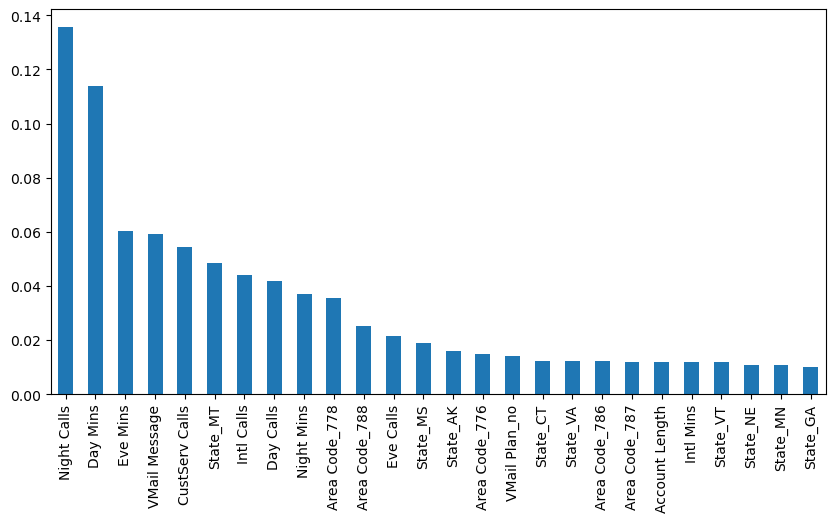

In [19]:
pd.Series(clf.feature_importances_, index=clf.feature_names_in_)[lambda x: x > 0.01].sort_values(ascending=False).plot.bar(figsize=(10, 5))

データ分析の結果、解約しているか否かで分布に差があった `Night Calls` や `Day Minus` が重要と判断されています。夜間時間帯の通話や料金、品質やサービスに課題があるのかもしれません。実際のデータからは、特定プランに加入しているユーザーの解約率が特に高いことがわかるかもしれません。モデルの解釈と人間の解釈があっていることを確認することは重要です。

---
## 7.評価 : Test

機械学習モデルができたので、ビジネス目標を達成できるかどうか評価を行います。

機械学習モデルの性能を評価した後、その機械学習モデルを使って解約防止のアクションを取った場合のコストを試算します。

### 7-1.性能評価

まず機械学習モデルの性能を評価します。

In [20]:
predictions = clf.predict_proba(test_x)
predictions = predictions[:, 1]

機械学習の性能を評価する方法はいくつかあります。今回は、顧客が解約する `1` と解約しない `0` を予測しますので、この混同行列を作成します。混合行列は以下のように表されます。行列の各要素には、予測が当たっていれば True 、はずれていれば False で、それに予測対象の種別 Positive / Negative を付与した名前が付けられています。

![environment_setup_003.png](./images/003.png)


In [21]:
confusion_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])
confusion_matrix

predictions  0.0  1.0
actual               
0            237   16
1             10  237

※ アルゴリズムにはランダムな要素があるので結果は必ずしも一致しません._

247人の解約者がいて、それらの237名 (true positives) を正しく予測できました。そして、16名の顧客は解約すると予測しましたが、解約していません (false positives)。10名の顧客は解約しないと予測したにもかかわらず解約してしまいました (false negatives)。

性能を評価する指標として、 主に精度(`Accuracy`)、適合率(`Precision`)、再現率(`Recall`)、という 3 つの指標があります。 3 つの指標はそれぞれ評価の観点が異なります。一般的には、適合率と再現率の調和平均である F1 を評価指標として使うことが多いです ( 以下の図は、[機械学習帳の学習ノート](https://github.com/icoxfog417/mlnote-note)の図を転用しています )。

![004.png](images/004.png)

`sklearn.metrics` の `classification_report` を使うと簡単に計算することができます。 F1 の値は `0.95` なのでよく予測できていそうです。

In [22]:
from sklearn.metrics import classification_report


print(classification_report(test_data.iloc[:, 0], np.round(predictions)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       253
           1       0.94      0.96      0.95       247

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



### 7-2. コスト分析

このモデルを使って解約防止のアクションを取った場合、どれぐらいのコストがかかるでしょうか? 目標は 1 顧客当たり 500円 以内でした。混同行列のそれぞれの要素にコストの割り振りを行います。

1. True Negative: 解約しない顧客を正確に予測できた場合、コストは発生しないため 0 円とします。
2. False Negative: 実際は解約してしまった場合です。失った顧客を再度獲得するコストとして、CAC の 200,000 円を設定します。
3. True Positive: 解約を予測できた場合、インセンティブとして 500 円までのインセンティブで解約を防止します。
3. False Positive: 実際は解約しなかった場合です。インセンティブ 500 円のインセンティブは本来不要だったことになります。

この設定で、コストの計算をしてみます。

In [23]:
cost_matrix = np.array([[0, 500], [200000, 500]])
cost_matrix

array([[     0,    500],
       [200000,    500]])

混同行列と掛け合わせてコストを算出します。

In [24]:
total_cost = confusion_matrix * cost_matrix
total_cost

predictions      0.0     1.0
actual                      
0                  0    8000
1            2000000  118500

コストの合計を顧客の人数で割って、一人当たりのコストを計算します。

In [25]:
np.sum(np.sum(total_cost)) / len(test_data)

4253.0

一人当たり4253円なので、約 8 倍の予算オーバーです。どうしたらコストを最適化できるでしょうか?

重要な点として、`xgboost` が出力する値は 0 から 1 までの連続値なので、四捨五入を行う `np.round()` という関数で解約する `1` と 解約しない `0` に分類していました。つまり、しきい値 0.5 で判断したということです。

> confusion_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=**np.round(predictions)**, rownames=['actual'], colnames=['predictions'])

直感的な理解のため、予測結果の連続値をみてみましょう。

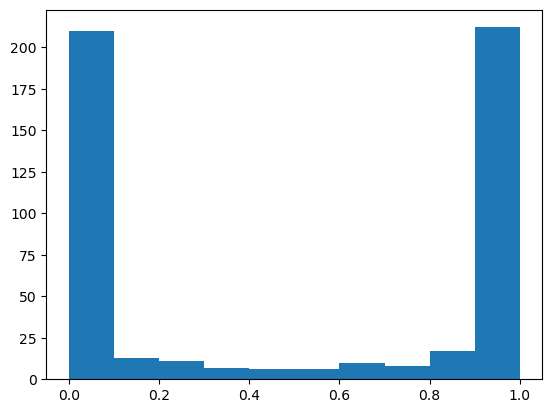

In [26]:
plt.hist(predictions)
plt.show()

解約しない 0 、 解約する 1 いずれかに偏っており、0.1 から 0.9 までの間でしきい値を設定するのはよさそうです。 `0.3` にしてみましょう。

In [27]:
confusion_matrix_changed = pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))
confusion_matrix_changed

col_0     0    1
Churn?          
0       228   25
1         6  241

In [28]:
confusion_matrix_changed - confusion_matrix

col_0   0  1
Churn?      
0      -9  9
1      -4  4

しきい値を0.5から0.3まで減らしてみたとき、true positives は 4 つ、false positives は 9 つ増え、false negatives は 4 つ減りました。全体の約 7% の顧客に対する予測結果が代わったことになります。解約を予測できなかった false negative の影響は大きいため、しきい値を 0.5 から下げて、可能性があれば解約するとみなすことはコスト最適化を行う上で重要そうです。

### 7-3.最適なしきい値を探す

コストの関数は以下のようなものになります。

```txt
cost(C) = 200,000 * FN(C) + 0 * TN(C) + 500 * FP(C) + 500 * TP(C)
```

FN(C) は false negative の割合で、しきい値 C(cutoff) の関数です。同様にTN, FP, TP も用意します。この関数の値が最小となるようなしきい値 C を探します。
最も単純な方法は、候補となる閾値 C で何度もシミュレーションをすることです。以下では100個の値に対してループで計算を行います。

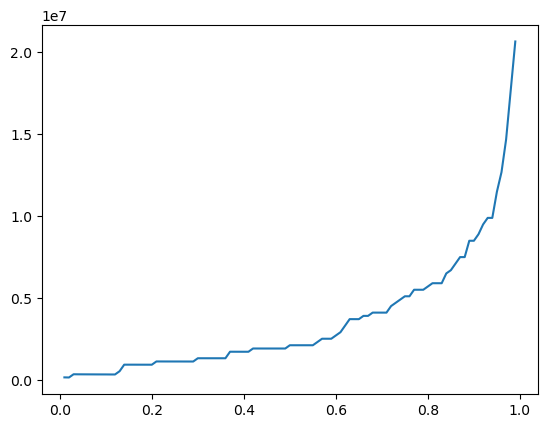

コストが最小となるしきい値は: 0.02 であり、その際のコストは: 159000 です。


In [29]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []

for c in cutoffs:
    _predictions = pd.Categorical(np.where(predictions > c, 1, 0), categories=[0, 1])
    _confusion_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=_predictions, dropna=False)
    costs.append(np.sum(np.sum(_confusion_matrix * cost_matrix)))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('コストが最小となるしきい値は:', cutoffs[np.argmin(costs)], 'であり、その際のコストは:', np.min(costs),'です。')

最適なしきい値の時のコストが得られました。顧客一人当たりのコストを計算してみましょう。

In [30]:
np.min(costs) / len(test_data)

318.0

目標の500円より低い値とできました。コスト目標は達成できましたが、解約率が目標の 0.6% になるかは機械学習モデルの検証だけではわかりません。なぜなら、解約しそうなことが分かった後に行われる解約防止のアクションにも依存するからです。 その意味では、まず解約の予測ができるかどうかと、予測した対象にアプローチすることで解約率を改善できるか、を別々のフェーズに分けて検証したほうが良いでしょう。

**Discussion**

*皆さんの会社では、誰が解約率防止のアクションを取っているでしょうか?*

機械学習プロジェクトの成果は機械学習モデルのみから得られるものではないことは覚えておくべきことです。ビジネス理解で作成した価値の計算式に関わる関係者と協力することで、はじめて目標が達成できます。